In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))


from offshore_wind_nj.data_loader import data_files, load_data, all_arrays, extract_datetime_from_filename, removed_files, load_single_data
from offshore_wind_nj.sar_wind_plot import plot_wind_field, plot_wind_field_by_arrays
from offshore_wind_nj.data_cleaning import fill_zeros, find_zeros, fill_nan, find_nan
from offshore_wind_nj.data_processing import flattened_data_list, scaled_data_list, fill_nan_all_arrays

2024-11-03 17:27:24.123 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: C:\Users\crist\OneDrive - montclair.edu\00.MSU_MsDataScience\2024.FALL(Offshore_research)\03.CODING\00.CCNM_OffshoreWind2425(Github)


There are 11 files
Scaled data list: 11


In [4]:
# fill_nan_all_arrays(all_arrays)

In [30]:
flattened_data_list = []
for speed, direction, lat, lon in all_arrays:
    # Assuming speed, direction, lat, lon are of shape (H, W) after NaN removal
    # Convert direction to Cartesian coordinates
    dir_cos = np.cos(np.radians(direction))  # Shape (H, W)
    dir_sin = np.sin(np.radians(direction))  # Shape (H, W)

    # Stack all values for the same pixel (flattening)
    flattened_data = np.column_stack((speed.flatten(), dir_cos.flatten(), dir_sin.flatten(), lat.flatten(), lon.flatten()))
    flattened_data_list.append(flattened_data)


In [32]:
flattened_data_list[0]

array([[  9.112082  ,  -0.9799002 ,  -0.1994884 ,  35.73571   ,
        -74.00143   ],
       [  8.611857  ,  -0.9798779 ,  -0.19959797,  35.737404  ,
        -73.99057   ],
       [  8.684312  ,  -0.9798555 ,  -0.19970776,  35.739094  ,
        -73.97971   ],
       ...,
       [ 17.625313  ,  -0.66654694,  -0.745463  ,  37.62327   ,
        -71.55693   ],
       [ 17.644932  ,  -0.6665612 ,  -0.7454503 ,  37.624702  ,
        -71.545746  ],
       [ 17.653786  ,  -0.66656524,  -0.7454467 ,  37.626133  ,
        -71.53456   ]], dtype=float32)

In [35]:
c
# all_flattened_data

In [36]:
from sklearn.preprocessing import StandardScaler

# Step 2: Fit the scaler on the global data
scaler = StandardScaler()
scaler.fit(all_flattened_data)  # Fit to the global data


StandardScaler()

In [37]:
# Step 3: Transform each flattened array using the fitted scaler
scaled_data_list = []
for data in flattened_data_list:
    scaled_data = scaler.transform(data)  # Standardize using the global scaler
    scaled_data_list.append(scaled_data)


In [39]:
scaled_data_list[0].shape

(42585, 5)

In [40]:
# Step 4: Reshape scaled data back to (H, W, Channels)
reshaped_scaled_data_list = []
for idx, scaled_data in enumerate(scaled_data_list):
    # Get original shape of the current array (speed, direction, lat, lon)
    original_shape = all_arrays[idx][0].shape  # Assuming speed has the shape (H, W)
    reshaped_data = scaled_data.reshape(original_shape[0], original_shape[1], 5)  # (H, W, 5)
    reshaped_scaled_data_list.append(reshaped_data)


In [43]:
reshaped_scaled_data_list[0].shape

(167, 255, 5)

In [52]:
# Transpose each image in reshaped_scaled_data_list
reshaped_scaled_data_list_transposed = [np.transpose(image, (2, 0, 1)) for image in reshaped_scaled_data_list]


In [54]:
reshaped_scaled_data_list_transposed[0].shape

(5, 167, 255)

# Creating the dataset

In [133]:

import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        image_tensor = torch.tensor(image, dtype=torch.float32)
        return image_tensor


import random 
# Now, let's split the dataset
def split_dataset(images, train_ratio=0.7):
    num_images = len(images)
    indices = list(range(num_images))
    random.shuffle(indices)
    
    train_size = int(train_ratio * num_images)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    return train_indices, val_indices

In [134]:
train_indices, val_indices = split_dataset(reshaped_scaled_data_list_transposed)

In [135]:
train_indices

[6, 9, 1, 7, 5, 8, 3]

In [136]:
# Create the dataset with the transposed data
dataset = CustomImageDataset(reshaped_scaled_data_list_transposed)


In [137]:
# Create training and validation datasets
train_dataset = CustomImageDataset([reshaped_scaled_data_list_transposed[i] for i in train_indices])
val_dataset = CustomImageDataset([reshaped_scaled_data_list_transposed[i] for i in val_indices])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

# now the data loader

In [129]:
from torch.utils.data import DataLoader
# Define parameters
batch_size = 1  # You can adjust this as needed
shuffle = True  # Shuffle the dataset for training

# Create the data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn

class AdaptiveAutoencoder(nn.Module):
    def __init__(self):
        super(AdaptiveAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, stride=2, padding=1),  # Output: 32 x (H/2) x (W/2)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x (H/4) x (W/4)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: 128 x (H/8) x (W/8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Output: 256 x (H/16) x (W/16)
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 128 x (H/8) x (W/8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 64 x (H/4) x (W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: 32 x (H/2) x (W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 5, kernel_size=4, stride=2, padding=1)    # Output: 5 x (H) x (W)
        )
        
    def forward(self, x):
        # Get input dimensions
        batch_size, channels, height, width = x.size()
        
        # Encode
        encoded = self.encoder(x)
        
        # Decode
        decoded = self.decoder(encoded)
        
        # Resize the output to match the input dimensions
        decoded = nn.functional.interpolate(decoded, size=(height, width), mode='bilinear', align_corners=False)
        
        return decoded

# Example of instantiation and testing
autoencoder = AdaptiveAutoencoder()
images = torch.randn(1, 5, 167, 255)  # Example input tensor
output = model(images)
print(f'Input shape: {images.shape}, Reconstructed shape: {output.shape}')




Input shape: torch.Size([1, 5, 167, 255]), Reconstructed shape: torch.Size([1, 5, 167, 255])


In [47]:
for idx, image in enumerate(reshaped_scaled_data_list):
    # Transpose the image to the desired shape (5, H, W)
    image_input = np.transpose(image, (2, 0, 1))  # Shape: (5, H, W)
    print(f"Shape {image_input.shape}")
    # Convert to tensor without adding a batch dimension
    image_tensor = torch.tensor(image_input, dtype=torch.float32)  # Shape: (5, H, W)
    
    # Add a batch dimension for the autoencoder (this is needed because the model expects input with a batch dimension)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: (1, 5, H, W)

    # Forward pass through the autoencoder
    # reconstructed_image = autoencoder(image_tensor)  # Shape will be (1, 5, H, W)

    # # Compute loss (you may want to adjust how you handle loss calculation)
    # loss = criterion(reconstructed_image, image_tensor)  # Compare with the original image tensor

    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()


Shape (5, 167, 255)
Shape (5, 167, 255)
Shape (5, 150, 253)
Shape (5, 194, 252)
Shape (5, 167, 253)
Shape (5, 169, 252)
Shape (5, 193, 252)
Shape (5, 193, 257)
Shape (5, 194, 253)
Shape (5, 193, 255)
Shape (5, 167, 254)


In [131]:
# Define your device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the autoencoder to the appropriate device
autoencoder = AdaptiveAutoencoder().to(device)

# Training parameters
num_epochs = 100
learning_rate = 0.0001

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_losses = []
val_losses = []  
# Training loop
for epoch in range(num_epochs):
    for images in data_loader:
        # Move the images to the appropriate device
        images = images.to(device)
        
        # Forward pass: Pass images through the autoencoder
        reconstructed_images = autoencoder(images)
        # print(f'Input shape: {images.shape}, Reconstructed shape: {reconstructed_images.shape}')

        # Compute the loss
        loss = criterion(reconstructed_images, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

    # Print loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.8305
Epoch [2/100], Loss: 0.9857
Epoch [3/100], Loss: 0.5716
Epoch [4/100], Loss: 1.4305
Epoch [5/100], Loss: 0.4656
Epoch [6/100], Loss: 1.2342
Epoch [7/100], Loss: 0.8396
Epoch [8/100], Loss: 0.8747
Epoch [9/100], Loss: 1.4527
Epoch [10/100], Loss: 0.4460
Epoch [11/100], Loss: 0.4524
Epoch [12/100], Loss: 0.6962
Epoch [13/100], Loss: 1.4377
Epoch [14/100], Loss: 0.5706
Epoch [15/100], Loss: 0.4216
Epoch [16/100], Loss: 0.5586
Epoch [17/100], Loss: 0.7153
Epoch [18/100], Loss: 0.4638
Epoch [19/100], Loss: 0.4200
Epoch [20/100], Loss: 0.5588
Epoch [21/100], Loss: 1.0623
Epoch [22/100], Loss: 0.9810
Epoch [23/100], Loss: 0.5173
Epoch [24/100], Loss: 0.3632
Epoch [25/100], Loss: 0.5085
Epoch [26/100], Loss: 0.3519
Epoch [27/100], Loss: 0.4649
Epoch [28/100], Loss: 0.2868
Epoch [29/100], Loss: 0.2671
Epoch [30/100], Loss: 0.5932
Epoch [31/100], Loss: 0.3775
Epoch [32/100], Loss: 0.4550
Epoch [33/100], Loss: 0.5159
Epoch [34/100], Loss: 0.2521
Epoch [35/100], Loss: 0

In [132]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define your device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the autoencoder to the appropriate device
autoencoder = AdaptiveAutoencoder().to(device)

# Training parameters
num_epochs = 400
learning_rate = 0.0001

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()  # Set the model to training mode
    total_train_loss = 0
    for images in train_loader:  # Use the training DataLoader
        # Move the images to the appropriate device
        images = images.to(device)

        # Forward pass: Pass images through the autoencoder
        reconstructed_images = autoencoder(images)

        # Compute the loss
        loss = criterion(reconstructed_images, images)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        total_train_loss += loss.item()  # Accumulate loss for the epoch

    # Record average training loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation phase
        autoencoder.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculation
            for val_images in val_loader:  # Use the validation DataLoader
                val_images = val_images.to(device)

                # Forward pass: Pass images through the autoencoder
                reconstructed_val_images = autoencoder(val_images)

                # Compute the validation loss
                val_loss = criterion(reconstructed_val_images, val_images)
                total_val_loss += val_loss.item()  # Accumulate validation loss

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Print training and validation loss every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')


Epoch [10/400], Training Loss: 0.8821, Validation Loss: 0.9047
Epoch [20/400], Training Loss: 0.6659, Validation Loss: 0.7946
Epoch [30/400], Training Loss: 0.4879, Validation Loss: 0.6355
Epoch [40/400], Training Loss: 0.3899, Validation Loss: 0.5186
Epoch [50/400], Training Loss: 0.3388, Validation Loss: 0.5284
Epoch [60/400], Training Loss: 0.3279, Validation Loss: 0.5529
Epoch [70/400], Training Loss: 0.2861, Validation Loss: 0.5305
Epoch [80/400], Training Loss: 0.2611, Validation Loss: 0.5241
Epoch [90/400], Training Loss: 0.2412, Validation Loss: 0.5258
Epoch [100/400], Training Loss: 0.2522, Validation Loss: 0.5150
Epoch [110/400], Training Loss: 0.2261, Validation Loss: 0.5237
Epoch [120/400], Training Loss: 0.2156, Validation Loss: 0.5278
Epoch [130/400], Training Loss: 0.2259, Validation Loss: 0.5489
Epoch [140/400], Training Loss: 0.1929, Validation Loss: 0.5328
Epoch [150/400], Training Loss: 0.1902, Validation Loss: 0.5352
Epoch [160/400], Training Loss: 0.2098, Validatio

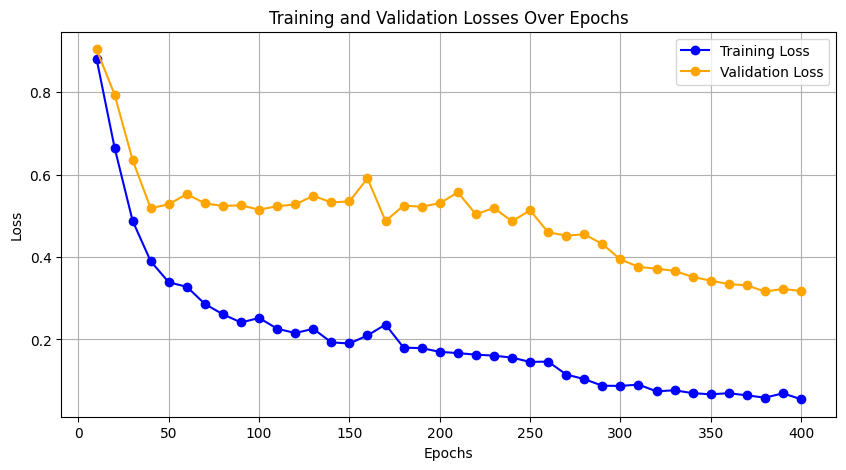

In [138]:
import matplotlib.pyplot as plt

# Ensure you have the correct lengths
x_epochs = range(10, num_epochs + 1, 10)  # This should still be (40,)
# Assuming you adjusted your train_losses and val_losses lists accordingly

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(x_epochs, val_losses, label='Validation Loss', color='orange', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Custom Dataset class for multi-channel image data

In [35]:
class MultiChannelImageDataset(Dataset):
    def __init__(self, image_arrays):
        # Each element in image_arrays is a tuple: (speed, cos(direction), sin(direction), latitude, longitude)
        self.images = image_arrays

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Stack the channels along a new dimension to create a multi-channel image
        image = np.stack(self.images[idx], axis=0)  # Shape: (5, H, W)
        return torch.tensor(image, dtype=torch.float32)

In [46]:
np.stack(all_arrays[0], axis = 0)#.shape

array([[[  9.112082 ,   8.611857 ,   8.684312 , ...,  16.634079 ,
                 nan,         nan],
        [  8.777194 ,   8.815788 ,   8.354136 , ...,  16.917137 ,
                 nan,         nan],
        [  9.870857 ,   9.256445 ,   8.219499 , ...,  16.885883 ,
                 nan,         nan],
        ...,
        [  8.042099 ,   7.2268963,   7.3592315, ...,  17.846361 ,
                 nan,         nan],
        [  7.2899995,   7.4636827,   7.2250953, ...,  17.870579 ,
                 nan,         nan],
        [  7.188838 ,   7.329113 ,   7.0611677, ...,  17.625313 ,
                 nan,         nan]],

       [[191.50705  , 191.51346  , 191.51987  , ..., 158.12077  ,
                 nan,         nan],
        [191.50699  , 191.51338  , 191.51979  , ..., 158.12125  ,
                 nan,         nan],
        [199.00691  , 194.01332  , 189.01973  , ..., 158.12172  ,
                 nan,         nan],
        ...,
        [198.99504  , 196.5018   , 196.50856  , ..., 2

In [54]:
scaled_data_list[0].shape

(42251, 5)

In [53]:
all_arrays[0][0].shape

(167, 255)

In [18]:
from collections import Counter

def count_shapes(data):
    # Create a Counter to hold the shape counts
    shape_counts = Counter()
    
    # Iterate through each tuple in all_arrays
    for arrays in data:
        # Get the shapes of each element in the tuple
        shapes = tuple(arr.shape for arr in arrays)
        # Update the Counter with this shape combination
        shape_counts[shapes] += 1
    
    return shape_counts

# Example usage
shape_summary = count_shapes(all_arrays)
print("Shape Summary:")
for shape, count in shape_summary.items():
    print(f"Shape: {shape}, Count: {count}")


Shape Summary:
Shape: ((167, 255), (167, 255), (167, 255), (167, 255)), Count: 2
Shape: ((150, 253), (150, 253), (150, 253), (150, 253)), Count: 1
Shape: ((194, 252), (194, 252), (194, 252), (194, 252)), Count: 1
Shape: ((167, 253), (167, 253), (167, 253), (167, 253)), Count: 1
Shape: ((169, 252), (169, 252), (169, 252), (169, 252)), Count: 1
Shape: ((193, 252), (193, 252), (193, 252), (193, 252)), Count: 1
Shape: ((193, 257), (193, 257), (193, 257), (193, 257)), Count: 1
Shape: ((194, 253), (194, 253), (194, 253), (194, 253)), Count: 1
Shape: ((193, 255), (193, 255), (193, 255), (193, 255)), Count: 1
Shape: ((167, 254), (167, 254), (167, 254), (167, 254)), Count: 1


# all_arrays

In [23]:
class MultiChannelImageDataset(Dataset):
    def __init__(self, scaled_data_list):
        self.images = scaled_data_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Access the tuple of arrays for the given index
        item = self.images[idx]
        
        # Check if the item is a tuple and has the correct structure
        if not isinstance(item, tuple) or len(item) != 5:
            raise ValueError(f"Expected a tuple of 5 arrays, but got {type(item)} with length {len(item)}")

        # Stack the channels along a new dimension to create a multi-channel image
        try:
            image = np.stack(item, axis=0)  # Shape: (5, H, W)
        except TypeError as e:
            print(f"Error stacking item at index {idx}: {e}")
            print(f"Item type: {type(item)}, content: {item}")
            raise e
            
        return torch.tensor(image, dtype=torch.float32)

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sample input data (replace with your actual data)
# all_arrays contains tuples of (speed, cos(direction), sin(direction), lat, lon)
# Each element is expected to have shape (H, W), e.g., (167, 255)

# Example: all_arrays = [(speed1, cos_dir1, sin_dir1, lat1, lon1), (speed2, cos_dir2, sin_dir2, lat2, lon2), ...]

# Step 1: Define Dataset Class
class MultiChannelImageDataset(Dataset):
    def __init__(self, scaled_data_list):
        self.images = scaled_data_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Access the tuple of arrays for the given index
        item = self.images[idx]
        
        # Check if the item is a tuple and has the correct structure
        if not isinstance(item, tuple) or len(item) != 5:
            raise ValueError(f"Expected a tuple of 5 arrays, but got {type(item)} with length {len(item)}")

        # Stack the channels along a new dimension to create a multi-channel image
        try:
            image = np.stack(item, axis=0)  # Shape: (5, H, W)
        except TypeError as e:
            print(f"Error stacking item at index {idx}: {e}")
            print(f"Item type: {type(item)}, content: {item}")
            raise e
            
        return torch.tensor(image, dtype=torch.float32)

# Step 2: Define the Model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=3, stride=2, padding=1),  # 5 input channels for speed, cos, sin, lat, lon
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # Kernel size adjusted to work with varied input dimensions
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 5, kernel_size=3, stride=2, padding=1, output_padding=1),  # 5 output channels
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Step 3: Prepare Dataset and DataLoader
all_arrays = [...]  # Load your data here
dataset = MultiChannelImageDataset(all_arrays)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Step 4: Initialize Model, Loss Function, and Optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for data in dataloader:
        # Forward pass
        output = model(data)
        loss = criterion(output, data)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Step 6: Feature Extraction Function
def extract_features(model, data):
    model.eval()
    with torch.no_grad():
        features = model.encoder(data)
    return features

# Step 7: Extract Features for Each Image
image_features = []
for data in dataloader:
    features = extract_features(model, data)
    image_features.append(features)

# Now, image_features contains the feature representations for each input sample
print("Feature extraction completed.")


TypeError: object of type 'ellipsis' has no len()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Sample data preparation (replace `all_arrays` with your actual data)
# all_arrays should contain tuples of (speed, cos(direction), sin(direction), lat, lon)
# Each element in the tuple should be a numpy array with the same shape, e.g., (H, W)
# Example:
# all_arrays = [(speed_array, cos_dir_array, sin_dir_array, lat_array, lon_array), ...]

# Custom Dataset class for multi-channel image data
class MultiChannelImageDataset(Dataset):
    def __init__(self, scaled_data_list):
        self.images = scaled_data_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Access the tuple of arrays for the given index
        item = self.images[idx]
        
        # Check if the item is a tuple and has the correct structure
        if not isinstance(item, tuple) or len(item) != 5:
            raise ValueError(f"Expected a tuple of 5 arrays, but got {type(item)} with length {len(item)}")

        # Stack the channels along a new dimension to create a multi-channel image
        try:
            image = np.stack(item, axis=0)  # Shape: (5, H, W)
        except TypeError as e:
            print(f"Error stacking item at index {idx}: {e}")
            print(f"Item type: {type(item)}, content: {item}")
            raise e
            
        return torch.tensor(image, dtype=torch.float32)

# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=3, stride=2, padding=1),  # 5 input channels for each variable
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # Adapt kernel size for variable image sizes
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 5, kernel_size=3, stride=2, padding=1, output_padding=1),  # 5 output channels
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the dataset and dataloader
dataset = MultiChannelImageDataset(all_arrays)  # all_arrays should contain tuples of (speed, cos(dir), sin(dir), lat, lon)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize model, loss function, and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for data in dataloader:
        # Forward pass
        output = model(data)
        loss = criterion(output, data)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Function to extract features from the encoder
def extract_features(model, data):
    model.eval()
    with torch.no_grad():
        features = model.encoder(data)
    return features

# Extract features for each image in the dataset
image_features = []
for data in dataloader:
    features = extract_features(model, data)
    image_features.append(features)

# Print feature shapes as a check
for i, features in enumerate(image_features):
    print(f"Image {i+1} features shape: {features.shape}")


TypeError: object of type 'ellipsis' has no len()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Dummy autoencoder model with convolutional layers
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # Adapt kernel for variable size
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Dummy dataset
class VariableSizeImageDataset(Dataset):
    def __init__(self, image_arrays):
        self.images = image_arrays

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Add channel dimension for PyTorch (e.g., grayscale: 1 channel)
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

# Assuming all_arrays contains numpy arrays of variable sizes
dataset = VariableSizeImageDataset([arr[0] for arr in all_arrays])  # use only 'speed' as example
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Batch size = 1 for variable sizes

# Model, loss function, optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for data in dataloader:
        # Move data to device if GPU is available
        # data = data.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, data)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


C:\Users\crist\anaconda3\envs\cris_env\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1, 194, 252])) that is different to the input size (torch.Size([1, 1, 196, 252])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (196) must match the size of tensor b (194) at non-singleton dimension 2